In [8]:
import pandas as pd
import re
import nltk
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import joblib

In [2]:
# Load your dataset
df = pd.read_csv("C:\\Users\\abhve\\Downloads\\trained.csv")

In [3]:
column = 'OR_user_description'
label_column = 'Annotate'

In [4]:
# Handle missing values
df[column] = df[column].fillna('')  # Replace NaN with an empty string

In [6]:
df['Annotate'] = df['Annotate'].apply(lambda x: str(x))
df['Annotate'] = df['Annotate'].str.replace(' ', '')
df['Annotate'] = df['Annotate'].apply(lambda x: x.lower())
unique_values = df['Annotate'].unique()
print(unique_values)


['ir' 'media' 'nu' 'incs' 'ncp' 'sss' 'antibjp' 'bjps' 'bjp' 'ss' 'ammk'
 'inc' 'ysrcps' 'cpim' 'aimim' 'aaps' 'tmc' 'nan' 'mnss' 'aiadmks']


In [7]:
# Convert all values to strings
df[column] = df[column].apply(lambda x: str(x))

In [9]:
# Text Preprocessing
df[column] = df[column].apply(lambda x: x.lower())
df[column] = df[column].apply(lambda x: contractions.fix(x))
punctuations_regex = "!#%&\'()\*+,-/:;<=>?@[\\]^_`{|}~.1234567890"
df[column] = df[column].apply(lambda x: re.sub('[%s]' % re.escape(punctuations_regex), ' ', x))
df[column] = df[column].apply(lambda x: ' '.join(nltk.word_tokenize(x)))

In [10]:
# Feature Extraction (TF-IDF)
TFIDF_PARAMS = {
    'strip_accents': 'ascii',
    'stop_words': 'english',
    'sublinear_tf': True, #number assignment- rare words more weight
    'ngram_range': (1, 4),
    'min_df': 0.003,
}

In [11]:
vectorizer = TfidfVectorizer(**TFIDF_PARAMS)
tfidf_model = vectorizer.fit(df[column])
features = tfidf_model.transform(df[column])

In [12]:
# Clustering
cluster_model = KMeans(n_clusters=200).fit(features)
df['cluster_label'] = cluster_model.labels_


C:\Users\abhve\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
# Encode Labels
label_encoder = LabelEncoder() #function
df[label_column] = label_encoder.fit_transform(df[label_column]) #function call


In [14]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, df[label_column], test_size=0.2, random_state=42)

In [15]:
# Training XGBoost (Weak supervision)
clf = XGBClassifier(n_jobs=-1, objective='multi:softmax')
clf = clf.fit(X_train, y_train)

In [16]:
# Save models
joblib.dump(clf, 'model.keras')
joblib.dump(tfidf_model, 'vectorizer.keras')
joblib.dump(label_encoder, 'label_encoder.keras')

['label_encoder.keras']

In [17]:
# Model Evaluation
y_true = label_encoder.inverse_transform(y_test)
y_pred = clf.predict(X_test)
y_pred_str = label_encoder.inverse_transform(y_pred)


In [18]:
print(classification_report(y_true, y_pred_str, digits=4))

              precision    recall  f1-score   support

        aaps     1.0000    1.0000    1.0000        27
     aiadmks     1.0000    1.0000    1.0000         4
       aimim     1.0000    0.8571    0.9231         7
        ammk     0.7500    1.0000    0.8571         3
     antibjp     1.0000    0.9198    0.9582       162
         bjp     1.0000    1.0000    1.0000        74
        bjps     1.0000    0.8133    0.8970       316
        cpim     1.0000    1.0000    1.0000         5
         inc     1.0000    1.0000    1.0000        61
        incs     0.9863    0.8780    0.9290        82
          ir     0.8580    1.0000    0.9236       580
       media     0.9985    0.9911    0.9948       673
        mnss     1.0000    1.0000    1.0000         6
         ncp     1.0000    1.0000    1.0000         8
          nu     1.0000    1.0000    1.0000       315
          ss     1.0000    1.0000    1.0000        12
         sss     1.0000    1.0000    1.0000        13
         tmc     1.0000    

In [29]:
## Testing

In [30]:
# Load your unlabeled dataset
unlabeled_df = pd.read_csv("C:\\Users\\abhve\\Downloads\\tested.csv")


In [31]:
column = 'OR_user_description'

In [32]:
unlabeled_df[column] = unlabeled_df[column].fillna('').astype(str)

In [33]:
# Text Preprocessing
unlabeled_df[column] = unlabeled_df[column].apply(lambda x: x.lower())
unlabeled_df[column] = unlabeled_df[column].apply(lambda x: contractions.fix(x))
punctuations_regex = "!#%&'()*+,-/:;<=>?@[\\]^_`{|}~.1234567890"
unlabeled_df[column] = unlabeled_df[column].apply(lambda x: re.sub('[%s]' % re.escape(punctuations_regex), ' ', x))
unlabeled_df[column] = unlabeled_df[column].apply(lambda x: ' '.join(nltk.word_tokenize(x)))


In [34]:
# Load TF-IDF vectorizer, label encoder, and model
tfidf_model = joblib.load('vectorizer.keras')
label_encoder = joblib.load('label_encoder.keras')
clf = joblib.load('model.keras')

In [35]:
# Feature extraction using the loaded TF-IDF vectorizer
features_unlabeled = tfidf_model.transform(unlabeled_df[column])

# Predict sentiment labels
predicted_labels = clf.predict(features_unlabeled)
predicted_sentiments = label_encoder.inverse_transform(predicted_labels)

# Add predicted sentiments to your unlabeled dataset
unlabeled_df['Annotate'] = predicted_sentiments

In [36]:
# Save the labeled dataset
unlabeled_df.to_csv("tested_tfidf.csv", index=False)


In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


['aaps' 'aiadmks' 'aimim' 'ammk' 'antibjp' 'bjp' 'bjps' 'cpim' 'inc'
 'incs' 'ir' 'media' 'mnss' 'nan' 'ncp' 'nu' 'ss' 'sss' 'tmc' 'ysrcps']


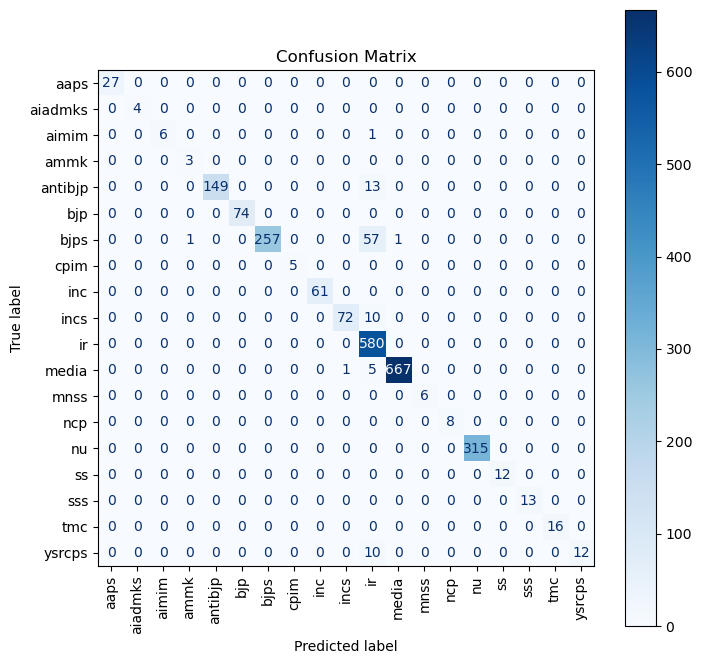

In [42]:
conf_matrix = confusion_matrix(y_true, y_pred_str)
classes = label_encoder.classes_
print(classes)
exclude_label = 'nan'
classes = [label for label in classes if label != exclude_label]

# Display Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(cmap='Blues', values_format='d', ax=ax)

# Rotate x-axis labels by 180 degrees
ax.set_xticklabels(classes, rotation=90)

plt.title('Confusion Matrix')
plt.show()